In [40]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


# Load the data
data = pd.read_csv('consumption_temp.csv')

# Filter for 'Oslo'
oslo_data = data[data['location'] == 'oslo']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(oslo_data[['consumption', 'temperature']])

def create_sequences(data, seq_length, pred_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length:i+seq_length+pred_length, 0])  # 'consumption' for the next 24 hours
    return torch.tensor(np.array(sequences)).float(), torch.tensor(np.array(target)).float()

seq_length = 120  # 5 days * 24 hours
pred_length = 24  # 1 day * 24 hours
X, y = create_sequences(scaled_data, seq_length, pred_length)


# Split into training and test sets
train_size = int(0.8 * len(X))
X_train_seq = X[:train_size]
y_train_seq = y[:train_size]
X_test_seq = X[train_size:]
y_test_seq = y[train_size:]


# Create DataLoader
batch_size = 64  # You can adjust this based on memory availability
train_dataset = TensorDataset(X_train_seq, y_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_seq, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, pred_length):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim * pred_length)  # Ensure the final layer produces pred_length outputs
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm2(out)
        out = self.dropout(out[:, -1, :])  # Use the last timestep output for prediction
        out = self.fc(out)
        return out

# Initialize the model, criterion, optimizer, and scheduler
input_dim = 2
hidden_dim = 100
num_layers = 2
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, pred_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):  # Wrap around tqdm for progress bar
    # Training
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_losses.append(running_loss / len(X_train_seq))

    # Evaluation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            running_val_loss += val_loss.item() * X_batch.size(0)
    val_losses.append(running_val_loss / len(X_test_seq))

    # Scheduler step
    scheduler.step()

print(train_losses)
print(val_losses)


100%|██████████| 50/50 [16:40<00:00, 20.02s/it]

[0.30235619202067693, 0.26139879252550074, 0.2577758433188225, 0.20657945581374537, 0.07177739460530895, 0.06049753389715552, 0.04797852232232449, 0.03569257154043684, 0.035659893771244976, 0.03660503569820517, 0.03473194117709078, 0.03305554971927473, 0.03198012791214515, 0.031738882430092874, 0.031700734492412175, 0.03161223862286209, 0.031080939867551553, 0.032044628909595856, 0.03171246694842045, 0.030688087562513934, 0.031437010827898175, 0.03121956817259961, 0.031443554606638294, 0.03171588620650449, 0.03171965157025156, 0.030630799113419625, 0.03060897924915662, 0.030295208808901592, 0.029960203705403202, 0.03028855940957794, 0.02957553759482493, 0.029467245306305654, 0.02935276725544548, 0.029135513804671026, 0.029377039496724693, 0.029249297304253748, 0.02913711552331994, 0.02851867315253376, 0.028400891938606548, 0.028661161587168343, 0.02478671909446101, 0.020487952032670374, 0.022259799007323076, 0.022075726464609955, 0.01845078104457572, 0.01838565983999412, 0.017758650484

In [41]:
print(X_train_seq.shape)
print(X_test_seq.shape)
print(y_train_seq.shape)
print(y_test_seq.shape)

torch.Size([6798, 120, 2])
torch.Size([1700, 120, 2])
torch.Size([6798, 24])
torch.Size([1700, 24])


In [43]:
import numpy as np

def make_predictions(new_data, model, scaler, seq_length, pred_length=24):
    # Assuming new_data is a DataFrame with 'consumption' and 'temperature' columns
    
    # Standardize the new data
    scaled_new_data = scaler.transform(new_data[['consumption', 'temperature']])
    
    # If data is less than sequence length, pad it
    if len(scaled_new_data) < seq_length:
        padding_length = seq_length - len(scaled_new_data)
        scaled_new_data = np.vstack((np.zeros((padding_length, scaled_new_data.shape[1])), scaled_new_data))

    # Extract the last `seq_length` data points for prediction
    X_new = scaled_new_data[-seq_length:]
    
    # Convert to tensor and add an additional dimension for batch size
    X_new = torch.tensor(X_new).float().unsqueeze(0)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(X_new)
    
    # Convert the scaled predictions back to the original scale
    # Only the consumption column (0th column) is considered from the predictions
    predictions_np = predictions.cpu().numpy().reshape(-1, 1)
    predictions_combined = np.hstack((predictions_np, np.zeros((predictions_np.shape[0], 1))))
    predictions_original_scale = scaler.inverse_transform(predictions_combined)[:, 0]
    
    return predictions_original_scale

# Example usage:
new_data = pd.DataFrame({"consumption": [100, 150, 200], "temperature": [15, 16, 17]})  # Just a dummy example
predicted_consumption = make_predictions(new_data, model, scaler, seq_length)
print(predicted_consumption)

[12.79012943 12.52736811 12.1644941  11.77520599 11.33800901 10.90222735
 10.51381928 10.2005616   9.96177559  9.80402594  9.73213061  9.75876751
  9.87020768 10.04801395 10.30646919 10.59873479 10.9300044  11.28058733
 11.64766103 12.01621299 12.3795894  12.68618745 12.87904385 12.94075045]


Mean Absolute Error (MAE): 0.20456469058990479
Mean Squared Error (MSE): 0.06683056801557541
Root Mean Squared Error (RMSE): 0.2585161030292511
R-squared: 0.4444714299736747
tensor([[[ 0.8124, -1.5043],
         [ 0.8444, -1.5043],
         [ 1.0537, -1.2648],
         ...,
         [ 1.5123, -2.3480],
         [ 1.4822, -2.3366],
         [ 1.4608, -2.3480]],

        [[ 0.8444, -1.5043],
         [ 1.0537, -1.2648],
         [ 1.2809, -1.3104],
         ...,
         [ 1.4822, -2.3366],
         [ 1.4608, -2.3480],
         [ 1.4697, -2.3594]],

        [[ 1.0537, -1.2648],
         [ 1.2809, -1.3104],
         [ 1.2124, -1.2420],
         ...,
         [ 1.4608, -2.3480],
         [ 1.4697, -2.3594],
         [ 1.4720, -2.3138]],

        ...,

        [[ 1.3156, -1.3902],
         [ 1.1677, -1.4358],
         [ 1.0487, -1.4700],
         ...,
         [ 1.2102, -0.3983],
         [ 1.1843, -0.7289],
         [ 1.0800, -0.8999]],

        [[ 1.1677, -1.4358],
         [ 1.0487, -1.4

/var/folders/k0/gx88kp513zqbj9_8ls33bwbh0000gn/T/ipykernel_27275/3937870214.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_data['time'] = pd.to_datetime(oslo_data['time'])


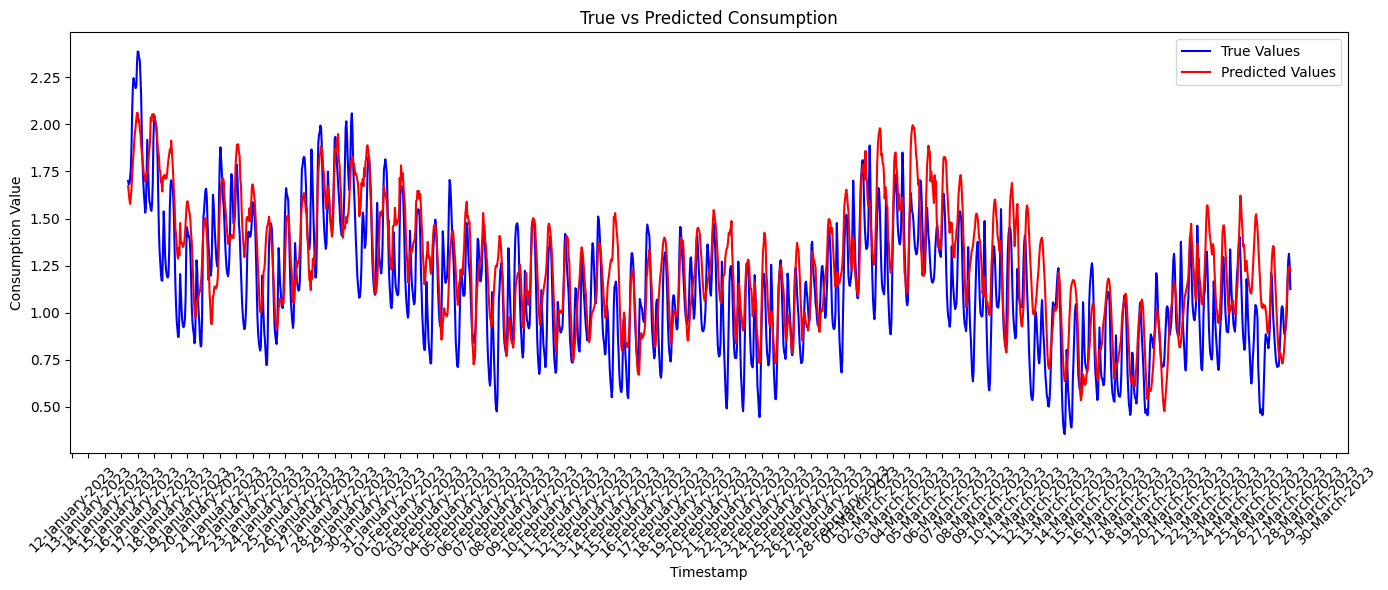

In [69]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq)

# Convert predictions and actual values to numpy arrays for calculation
y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test_seq.cpu().numpy()

# Compute Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

import matplotlib.pyplot as plt

# Get true values for the next 24 hours from each sequence
true_values = y_test_np[:, -1]  # Get the last value from each sequence

print(X_train_seq)
print(y_train_seq)
print(X_test_seq)
print(y_test_seq)

# Get the predicted values for 24 hours ahead
predicted_values = y_pred_np[:, -1]

# Convert the 'timestamp' column to datetime format
oslo_data['time'] = pd.to_datetime(oslo_data['time'])

# Get the starting timestamp of the test set
initial_timestamp = oslo_data['time'].iloc[train_size + seq_length]  # The start of the test set, adjusted for the sequence length

# Generate a range of timestamps for the test set, taking every 24th hour since we're predicting for 24 hours ahead
timestamps = [initial_timestamp + pd.Timedelta(hours=i*24) for i in range(len(true_values))]

# Extracting the start date from the test dataset
start_date = oslo_data.iloc[train_size]['time'].to_pydatetime()

# Generating timestamps for each hour in the test set
hours = len(y_test_seq)
timestamps = [start_date + timedelta(hours=i) for i in range(hours)]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(timestamps, true_values, label='True Values', color='blue')
plt.plot(timestamps, predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.title('True vs Predicted Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption Value')

# Customizing the x-axis to show a label only at the start of every new day
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%B-%Y'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))  # place a major tick every 24 hours (i.e., every day)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


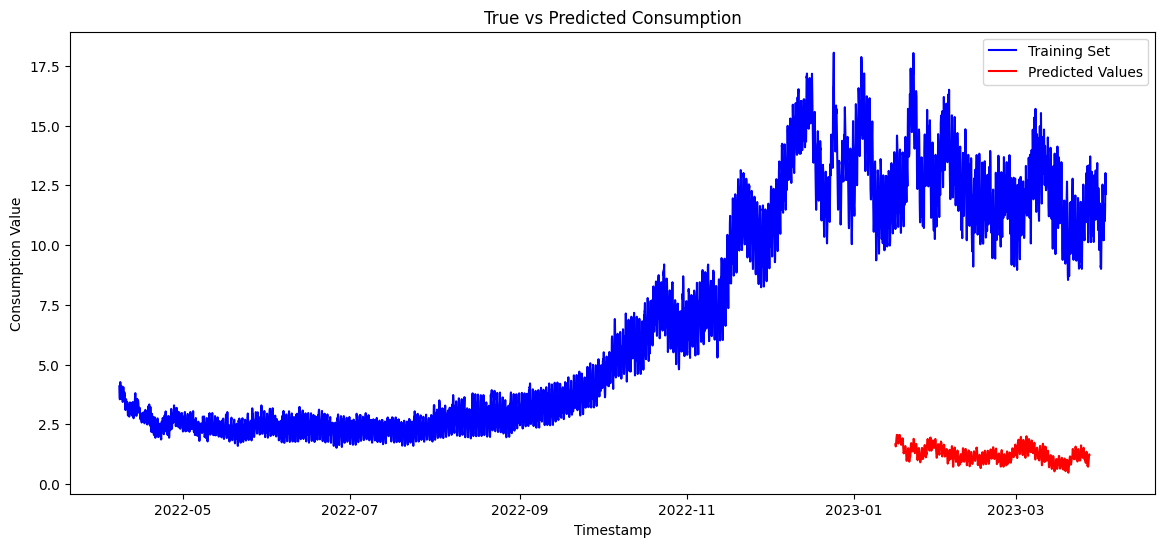

In [65]:
# Plot that includes the training set and the test set + the predictions
plt.figure(figsize=(14, 6))
plt.plot(oslo_data['time'], oslo_data['consumption'], label='Training Set', color='blue')
plt.plot(timestamps, predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.title('True vs Predicted Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption Value')
plt.show()